# Analysis of EMG signals 

## Imports

In [1]:
import emg_utils as myfct
import matplotlib.pyplot as plt
import scipy.signal as sp
from scipy.fft import fft
import pyemgpipeline as pep
import EntropyHub as EH
import numpy as np
from matplotlib.figure import SubplotParams
import os 
import pywt
import pandas as pd

## Global variables

In [2]:
SR = 1500 #sampling rate
emg_placement = 'Jarque-Bou'

## Path to mydata.csv folder

In [3]:
data_dir = r'../emg_recordings/12-01-2023/'
path_to_calibration = data_dir + 'torstein_calib_half/mydata.csv'
path_to_mydata = data_dir + 'torstein_task_2/mydata.csv'

## Plot raw data 

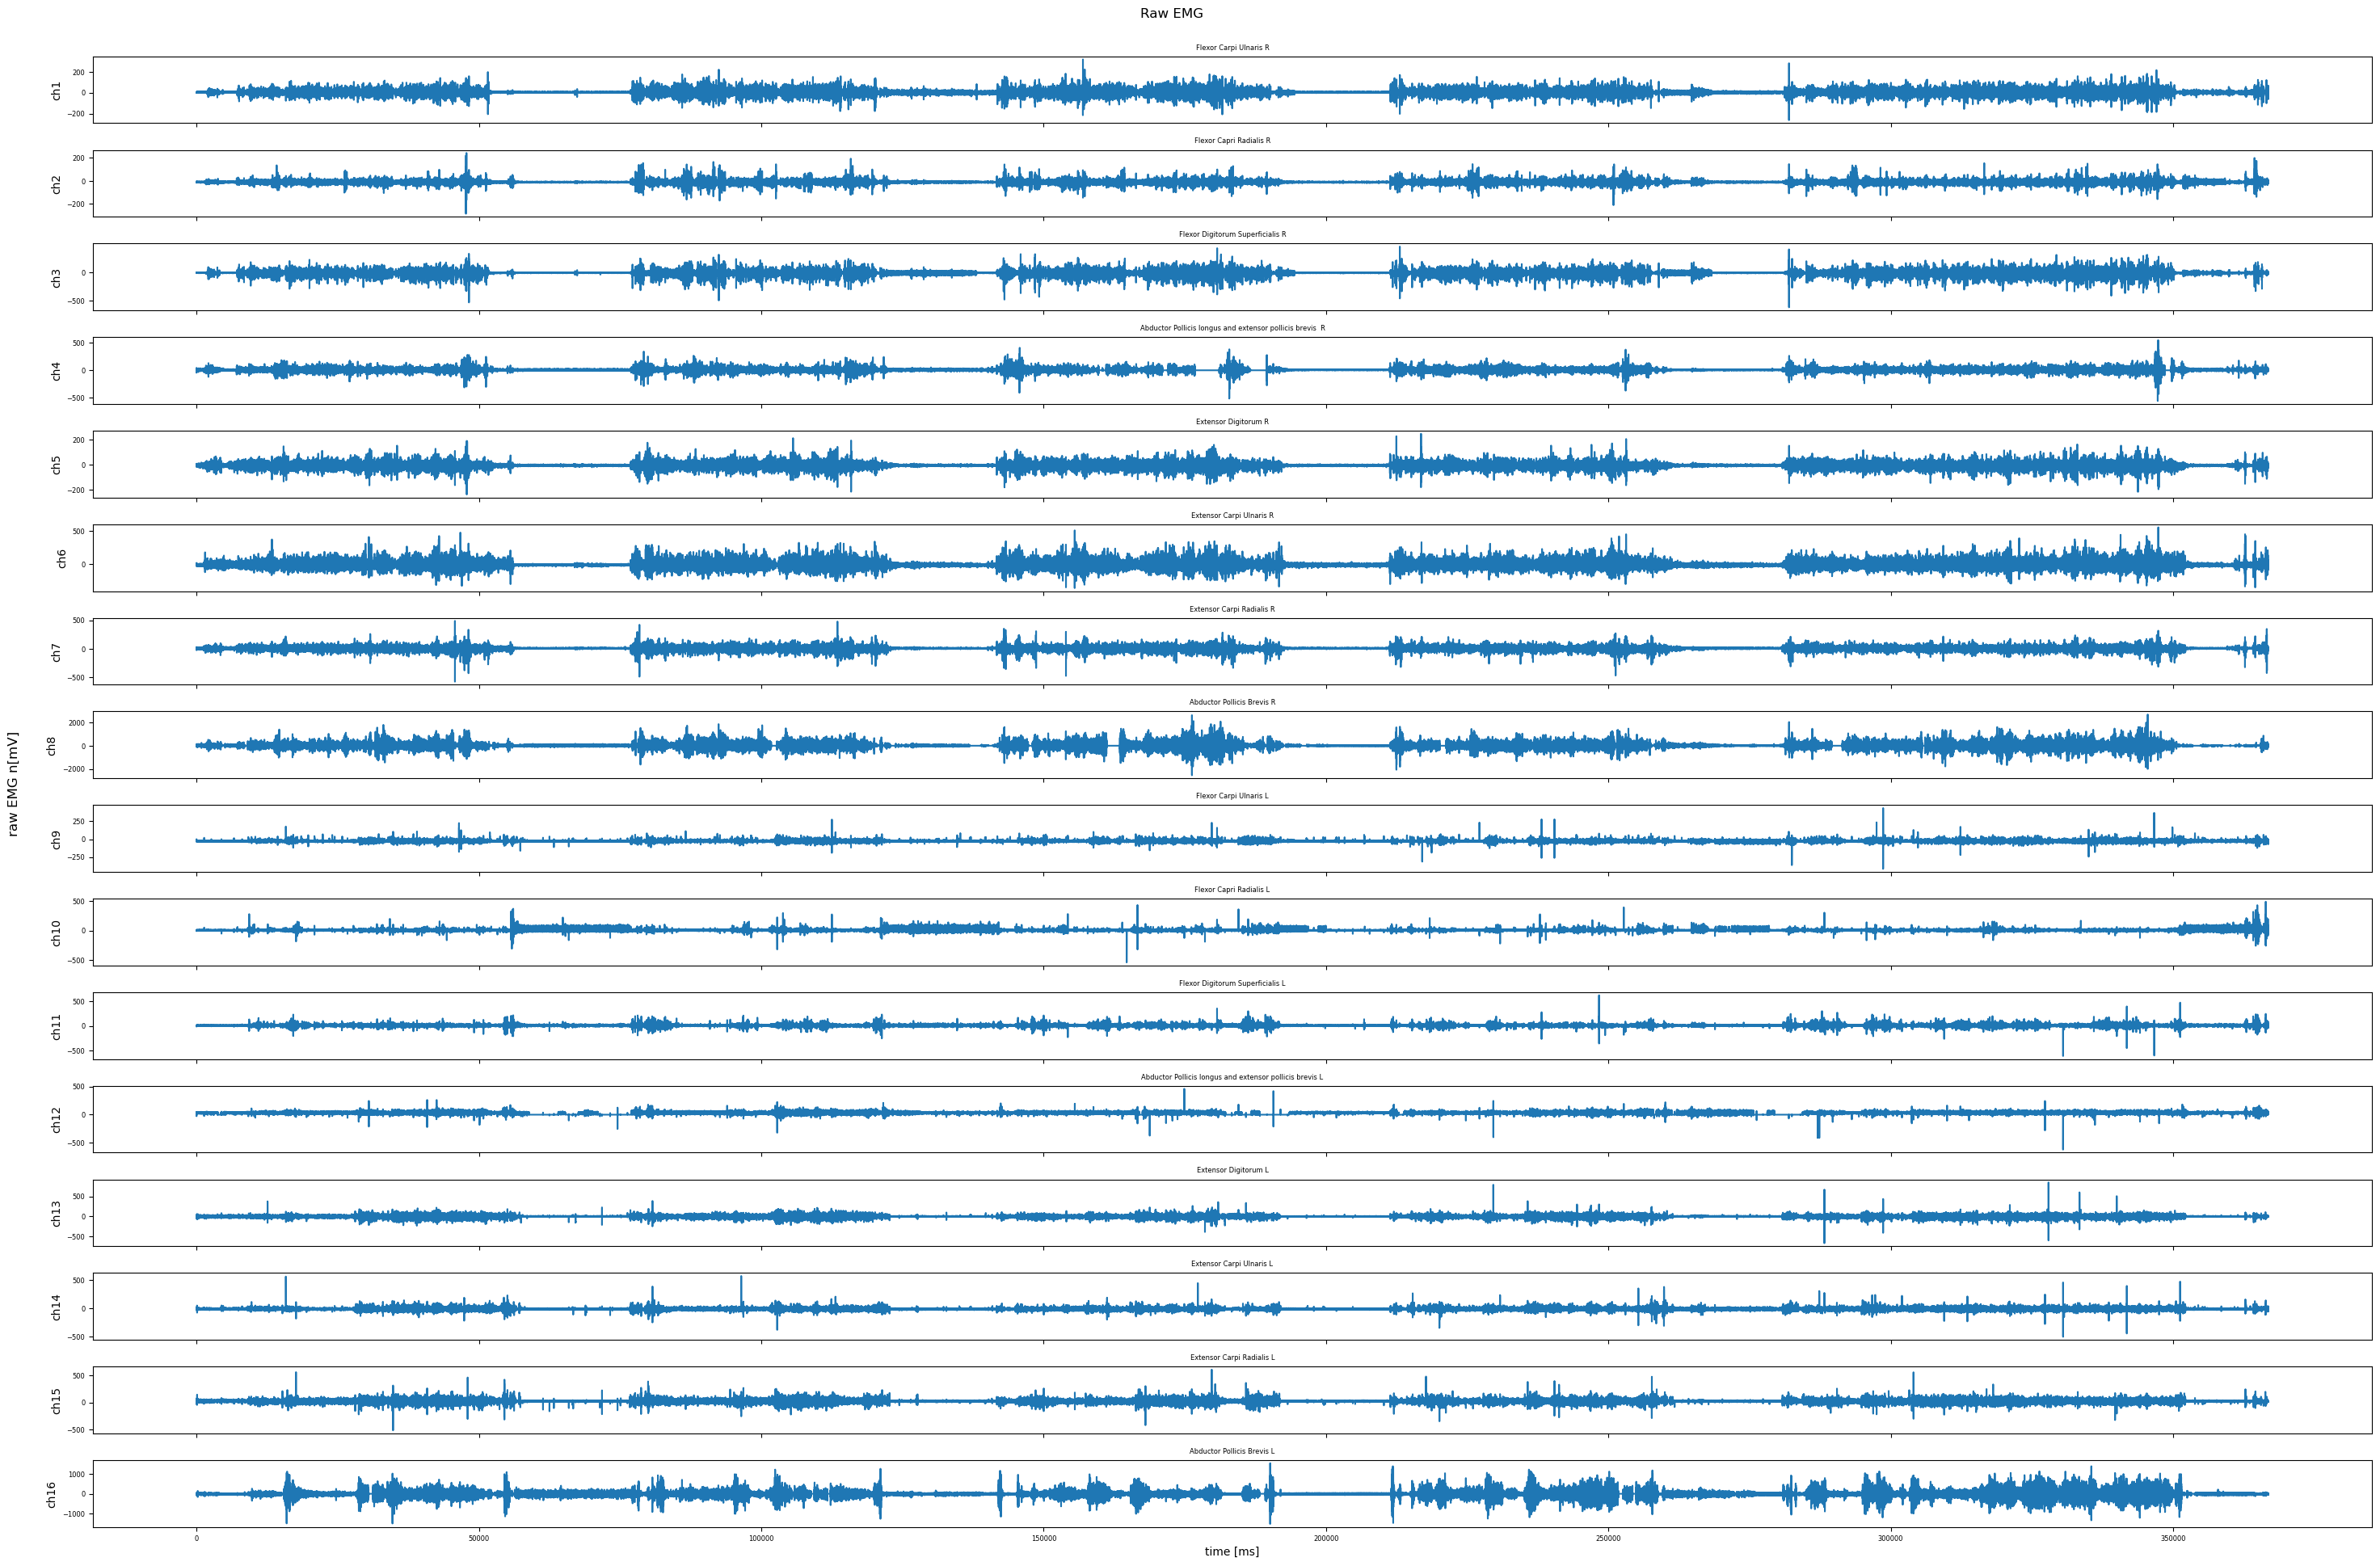

In [4]:
myfct.plot_mydata_raw(path_to_mydata)

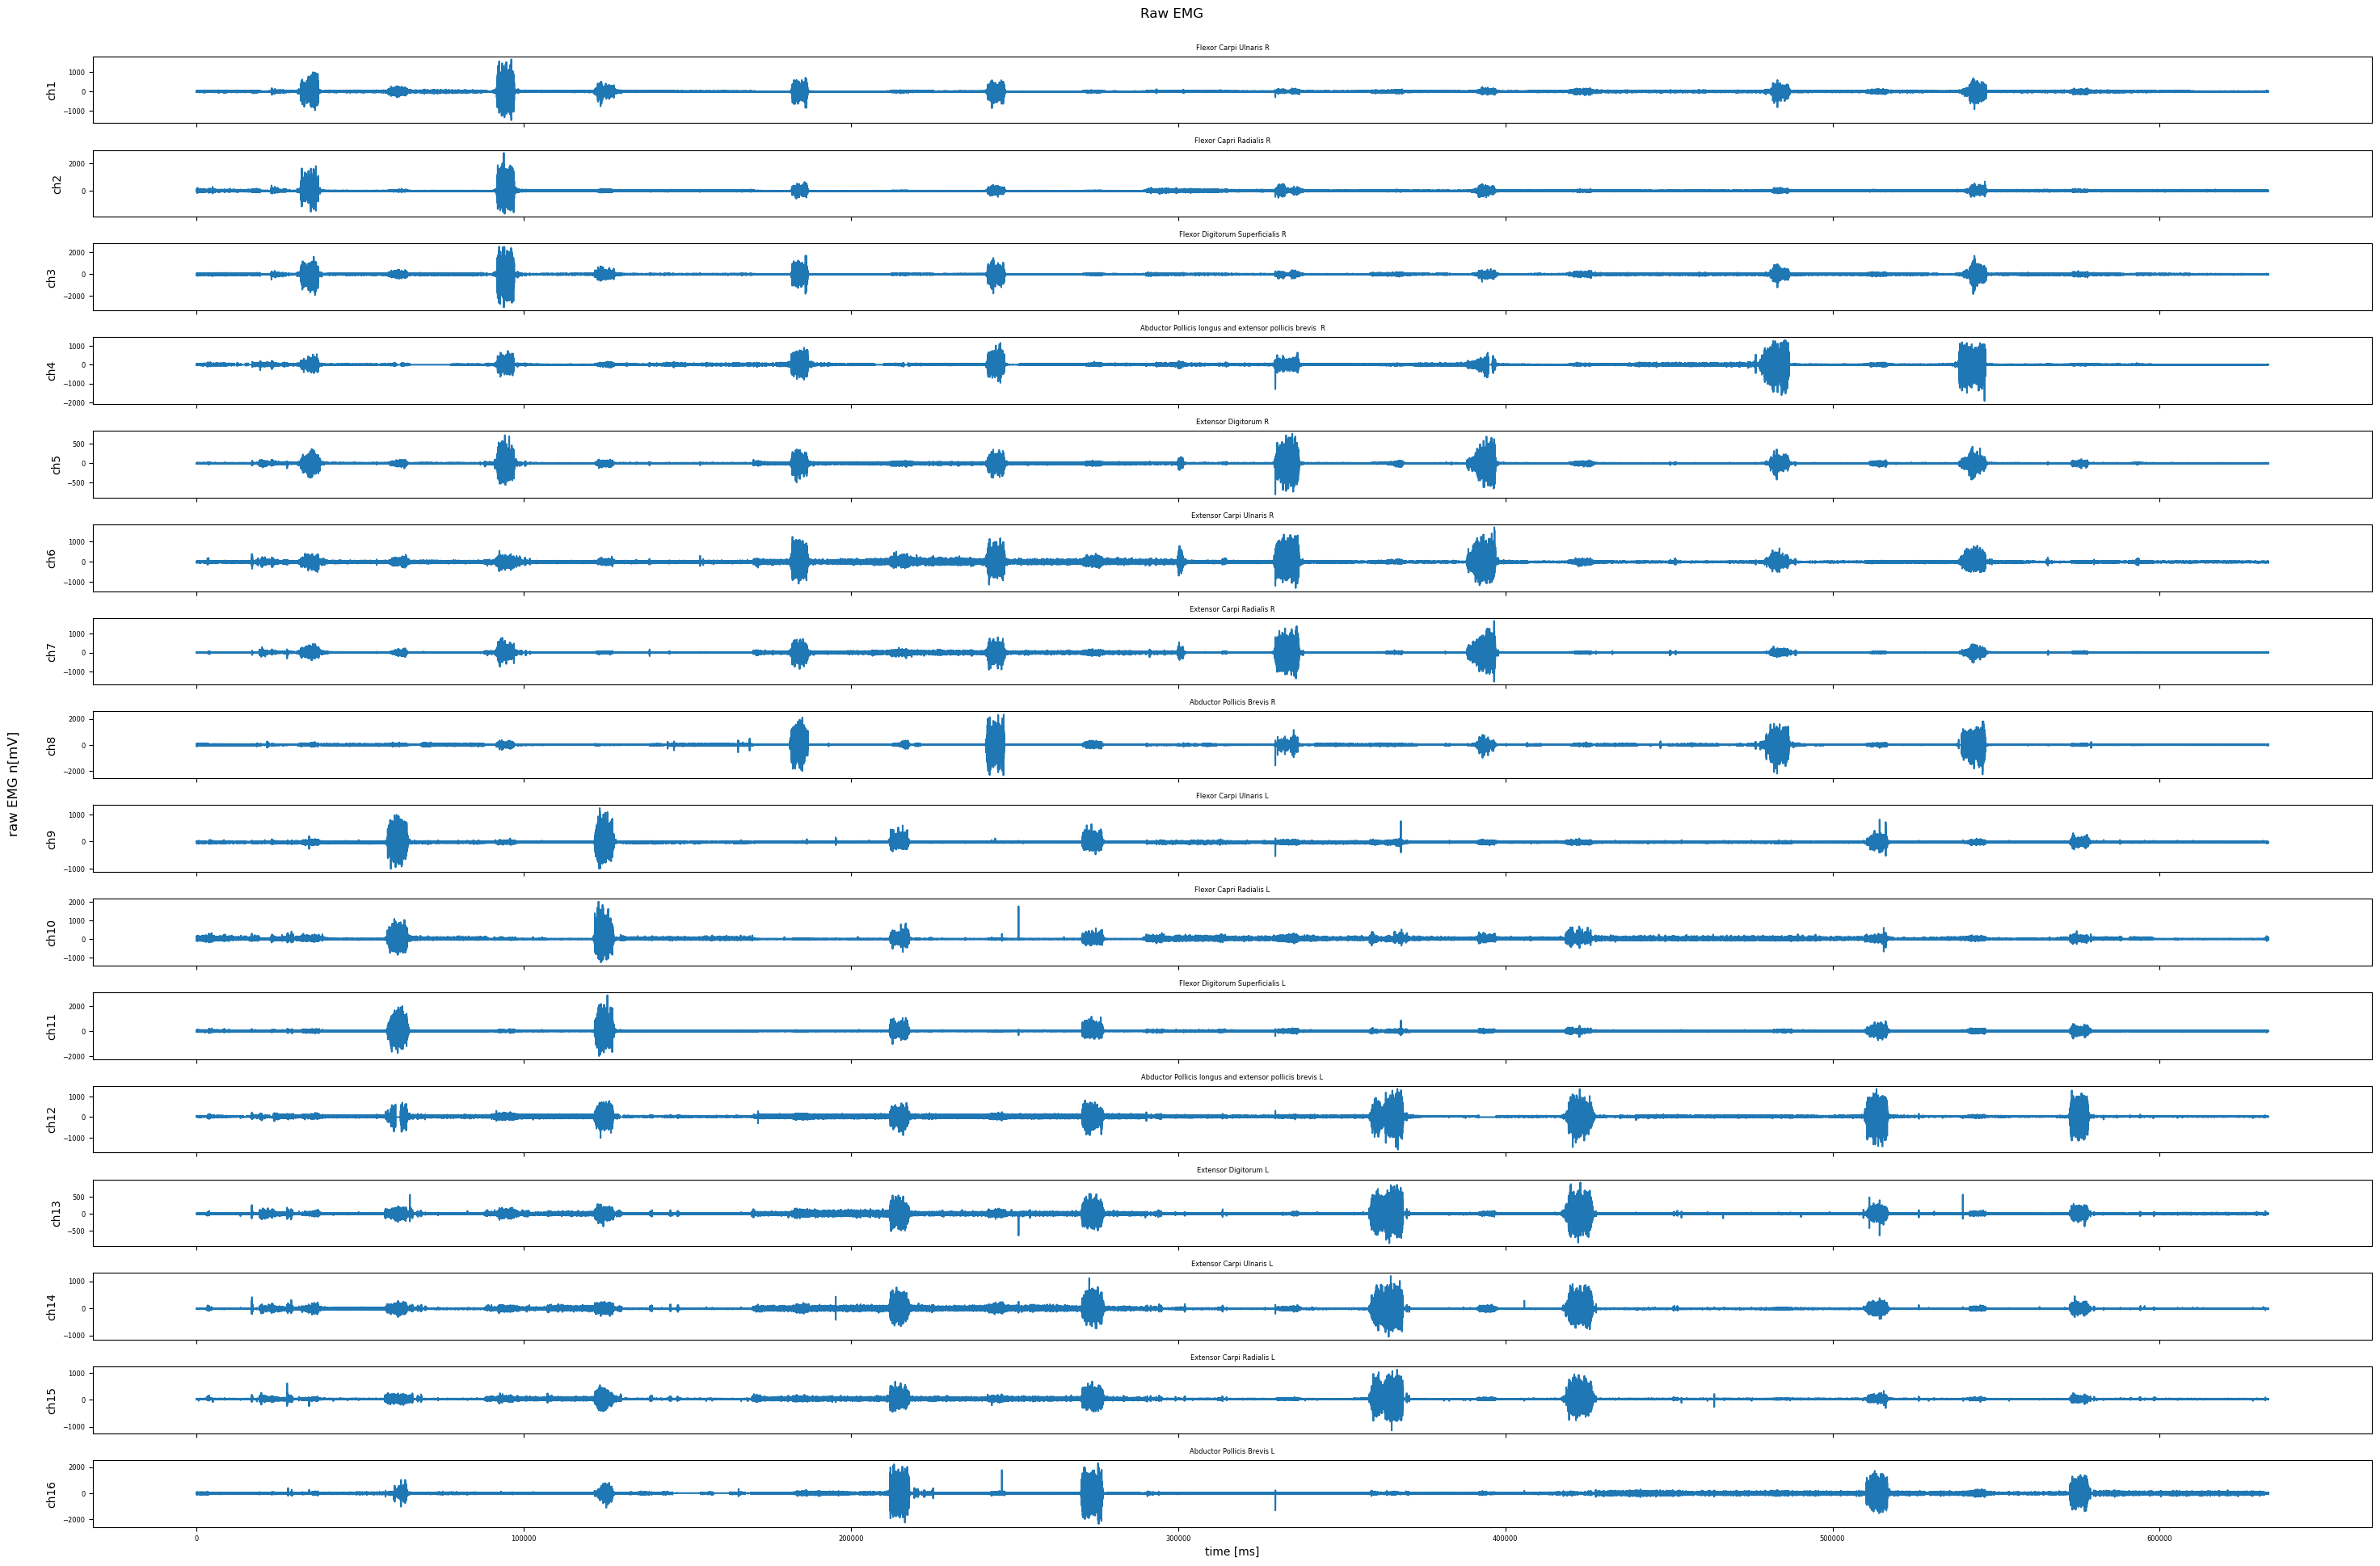

In [5]:
myfct.plot_mydata_raw(path_to_calibration)

## Data after clean_enmg function (right time arrays, remove nan + unexpected high values, remove DC offset, rectify)

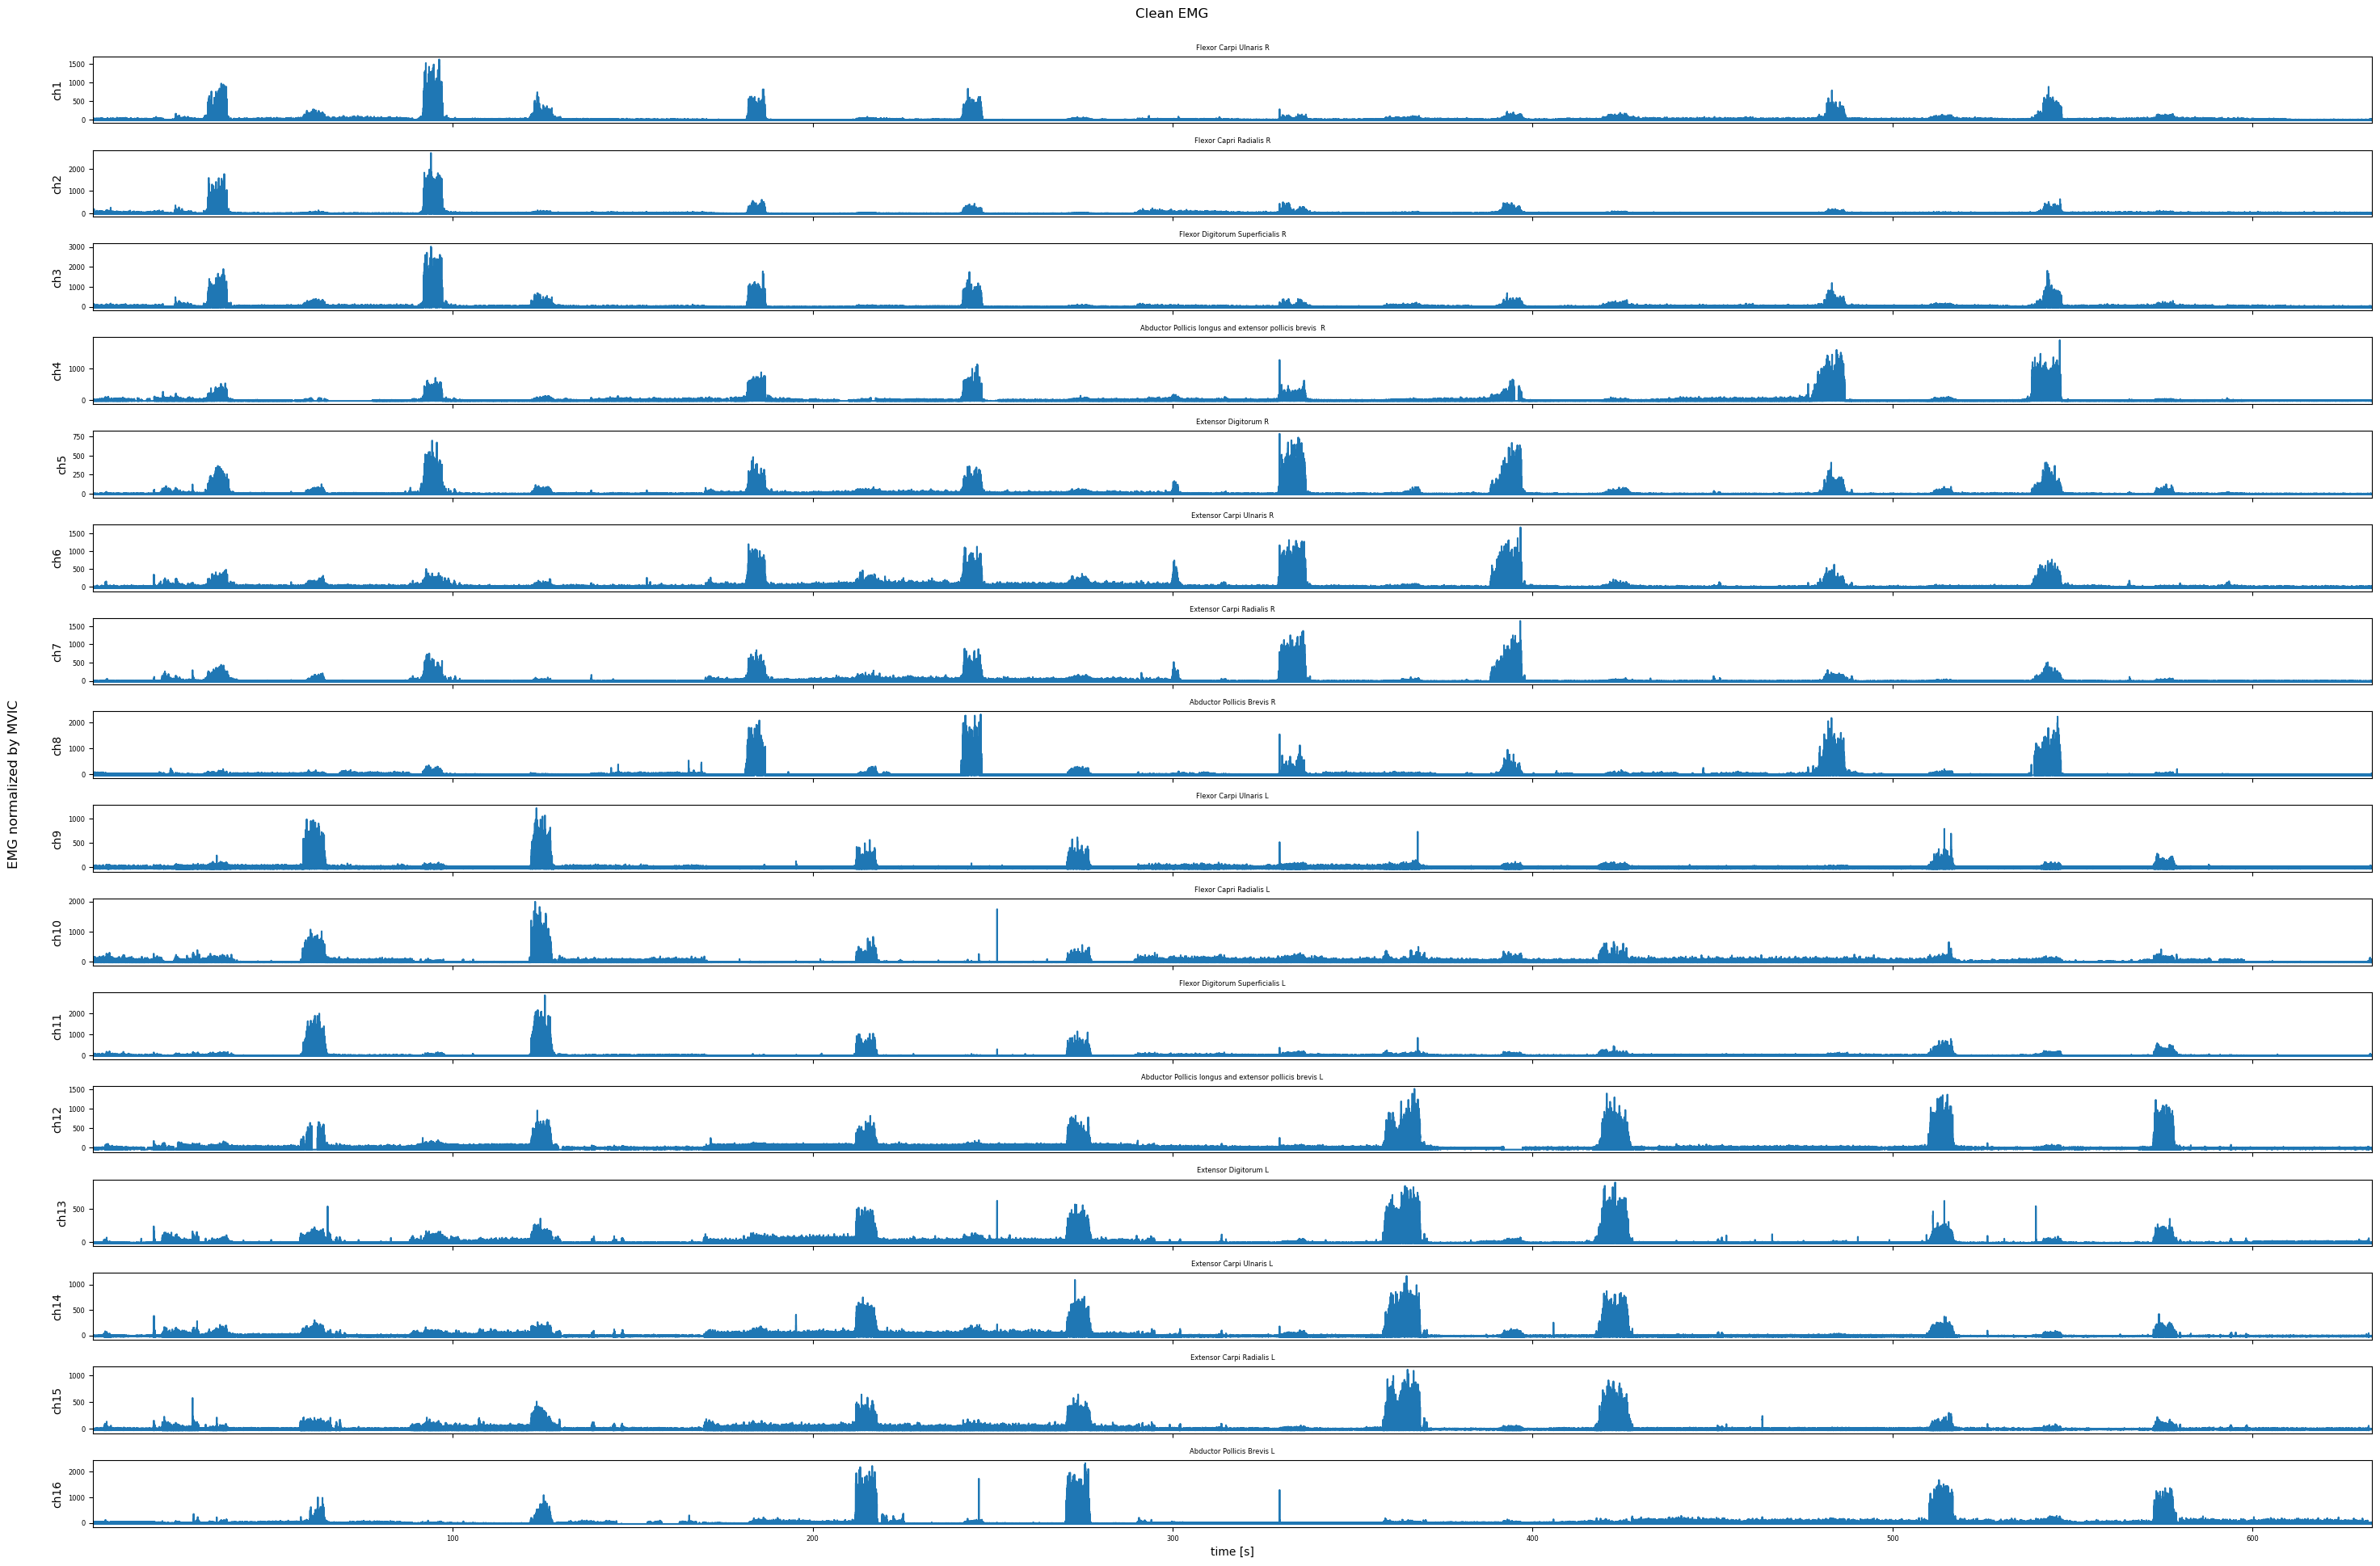

In [6]:
cleanemg_calib = myfct.clean_emg(path_to_calibration, emg_placement)   
cleanemgDF = myfct.clean_emg(path_to_mydata, emg_placement)   

myfct.plot_emgDF(cleanemg_calib)

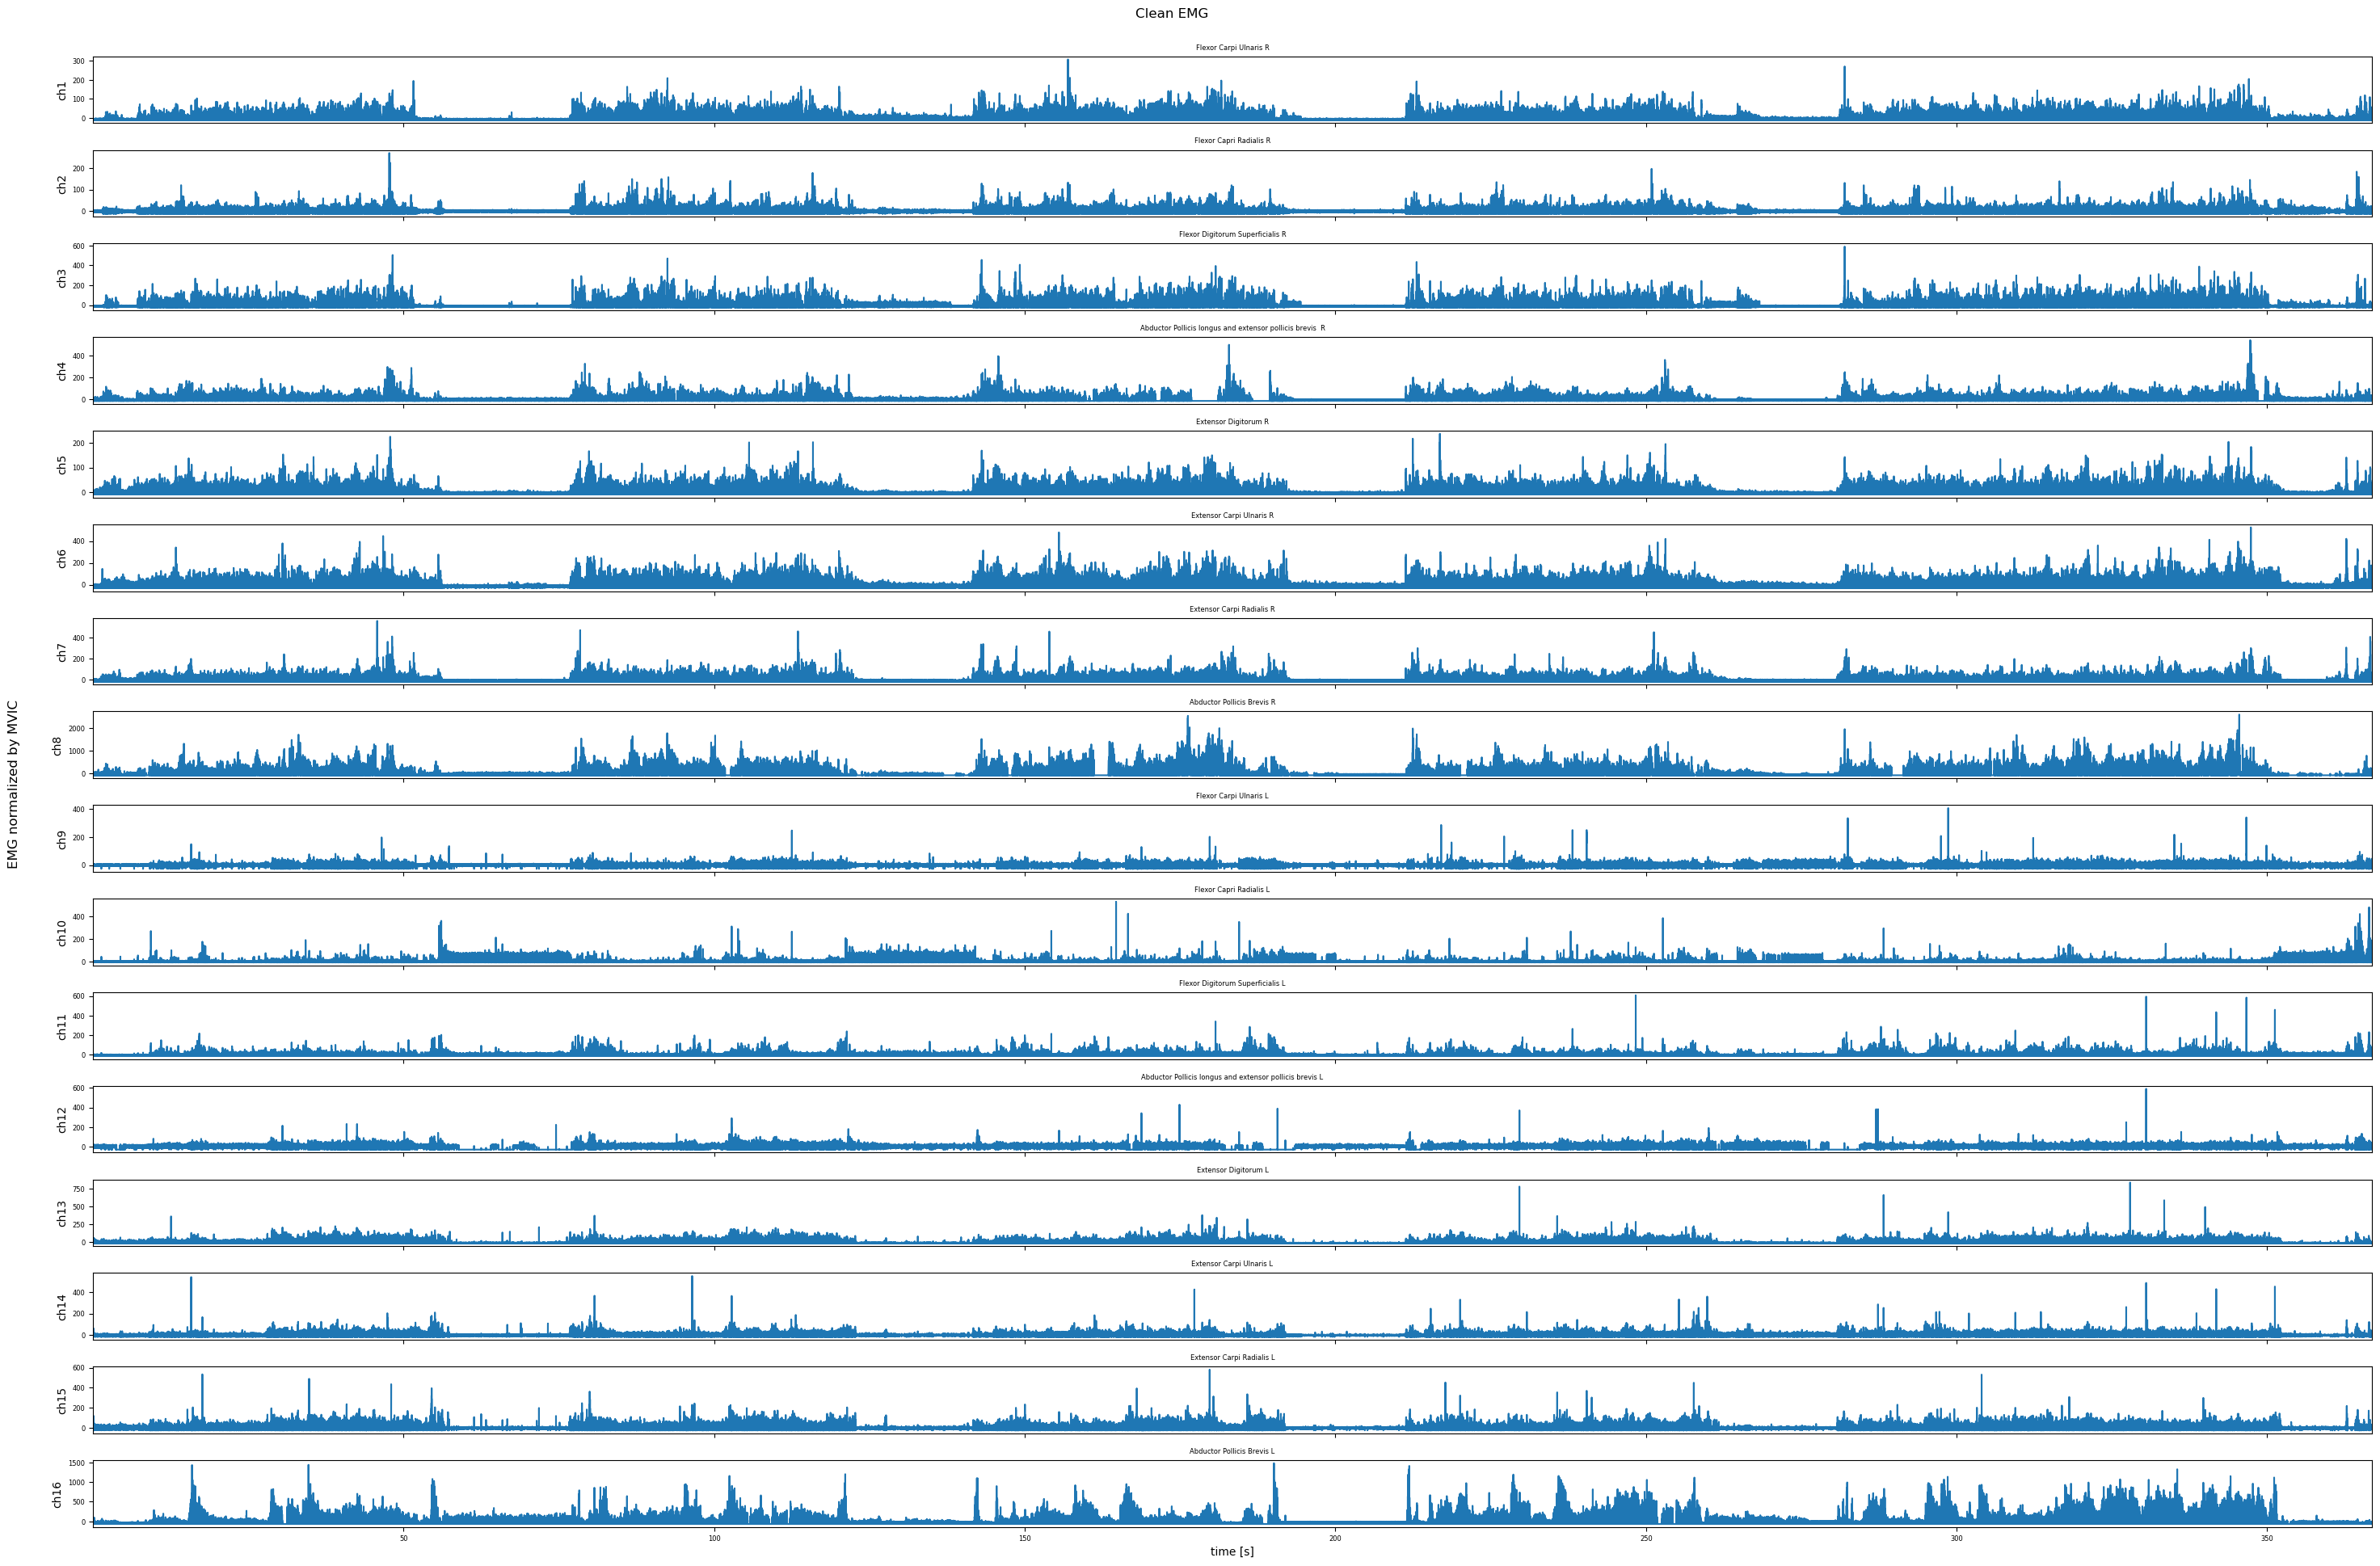

In [7]:
myfct.plot_emgDF(cleanemgDF)

In [8]:
print(f"Calibration recording duration : {cleanemg_calib['relative time'].iloc[-1]:.2f} s")
print(f"Recording duration : {cleanemgDF['relative time'].iloc[-1]:.2f} s")

Calibration recording duration : 633.21 s
Recording duration : 366.85 s


## Filters

### Butterworth

In [9]:
butt_calib = myfct.butterworth_filter(cleanemg_calib)
butt = myfct.butterworth_filter(cleanemgDF)

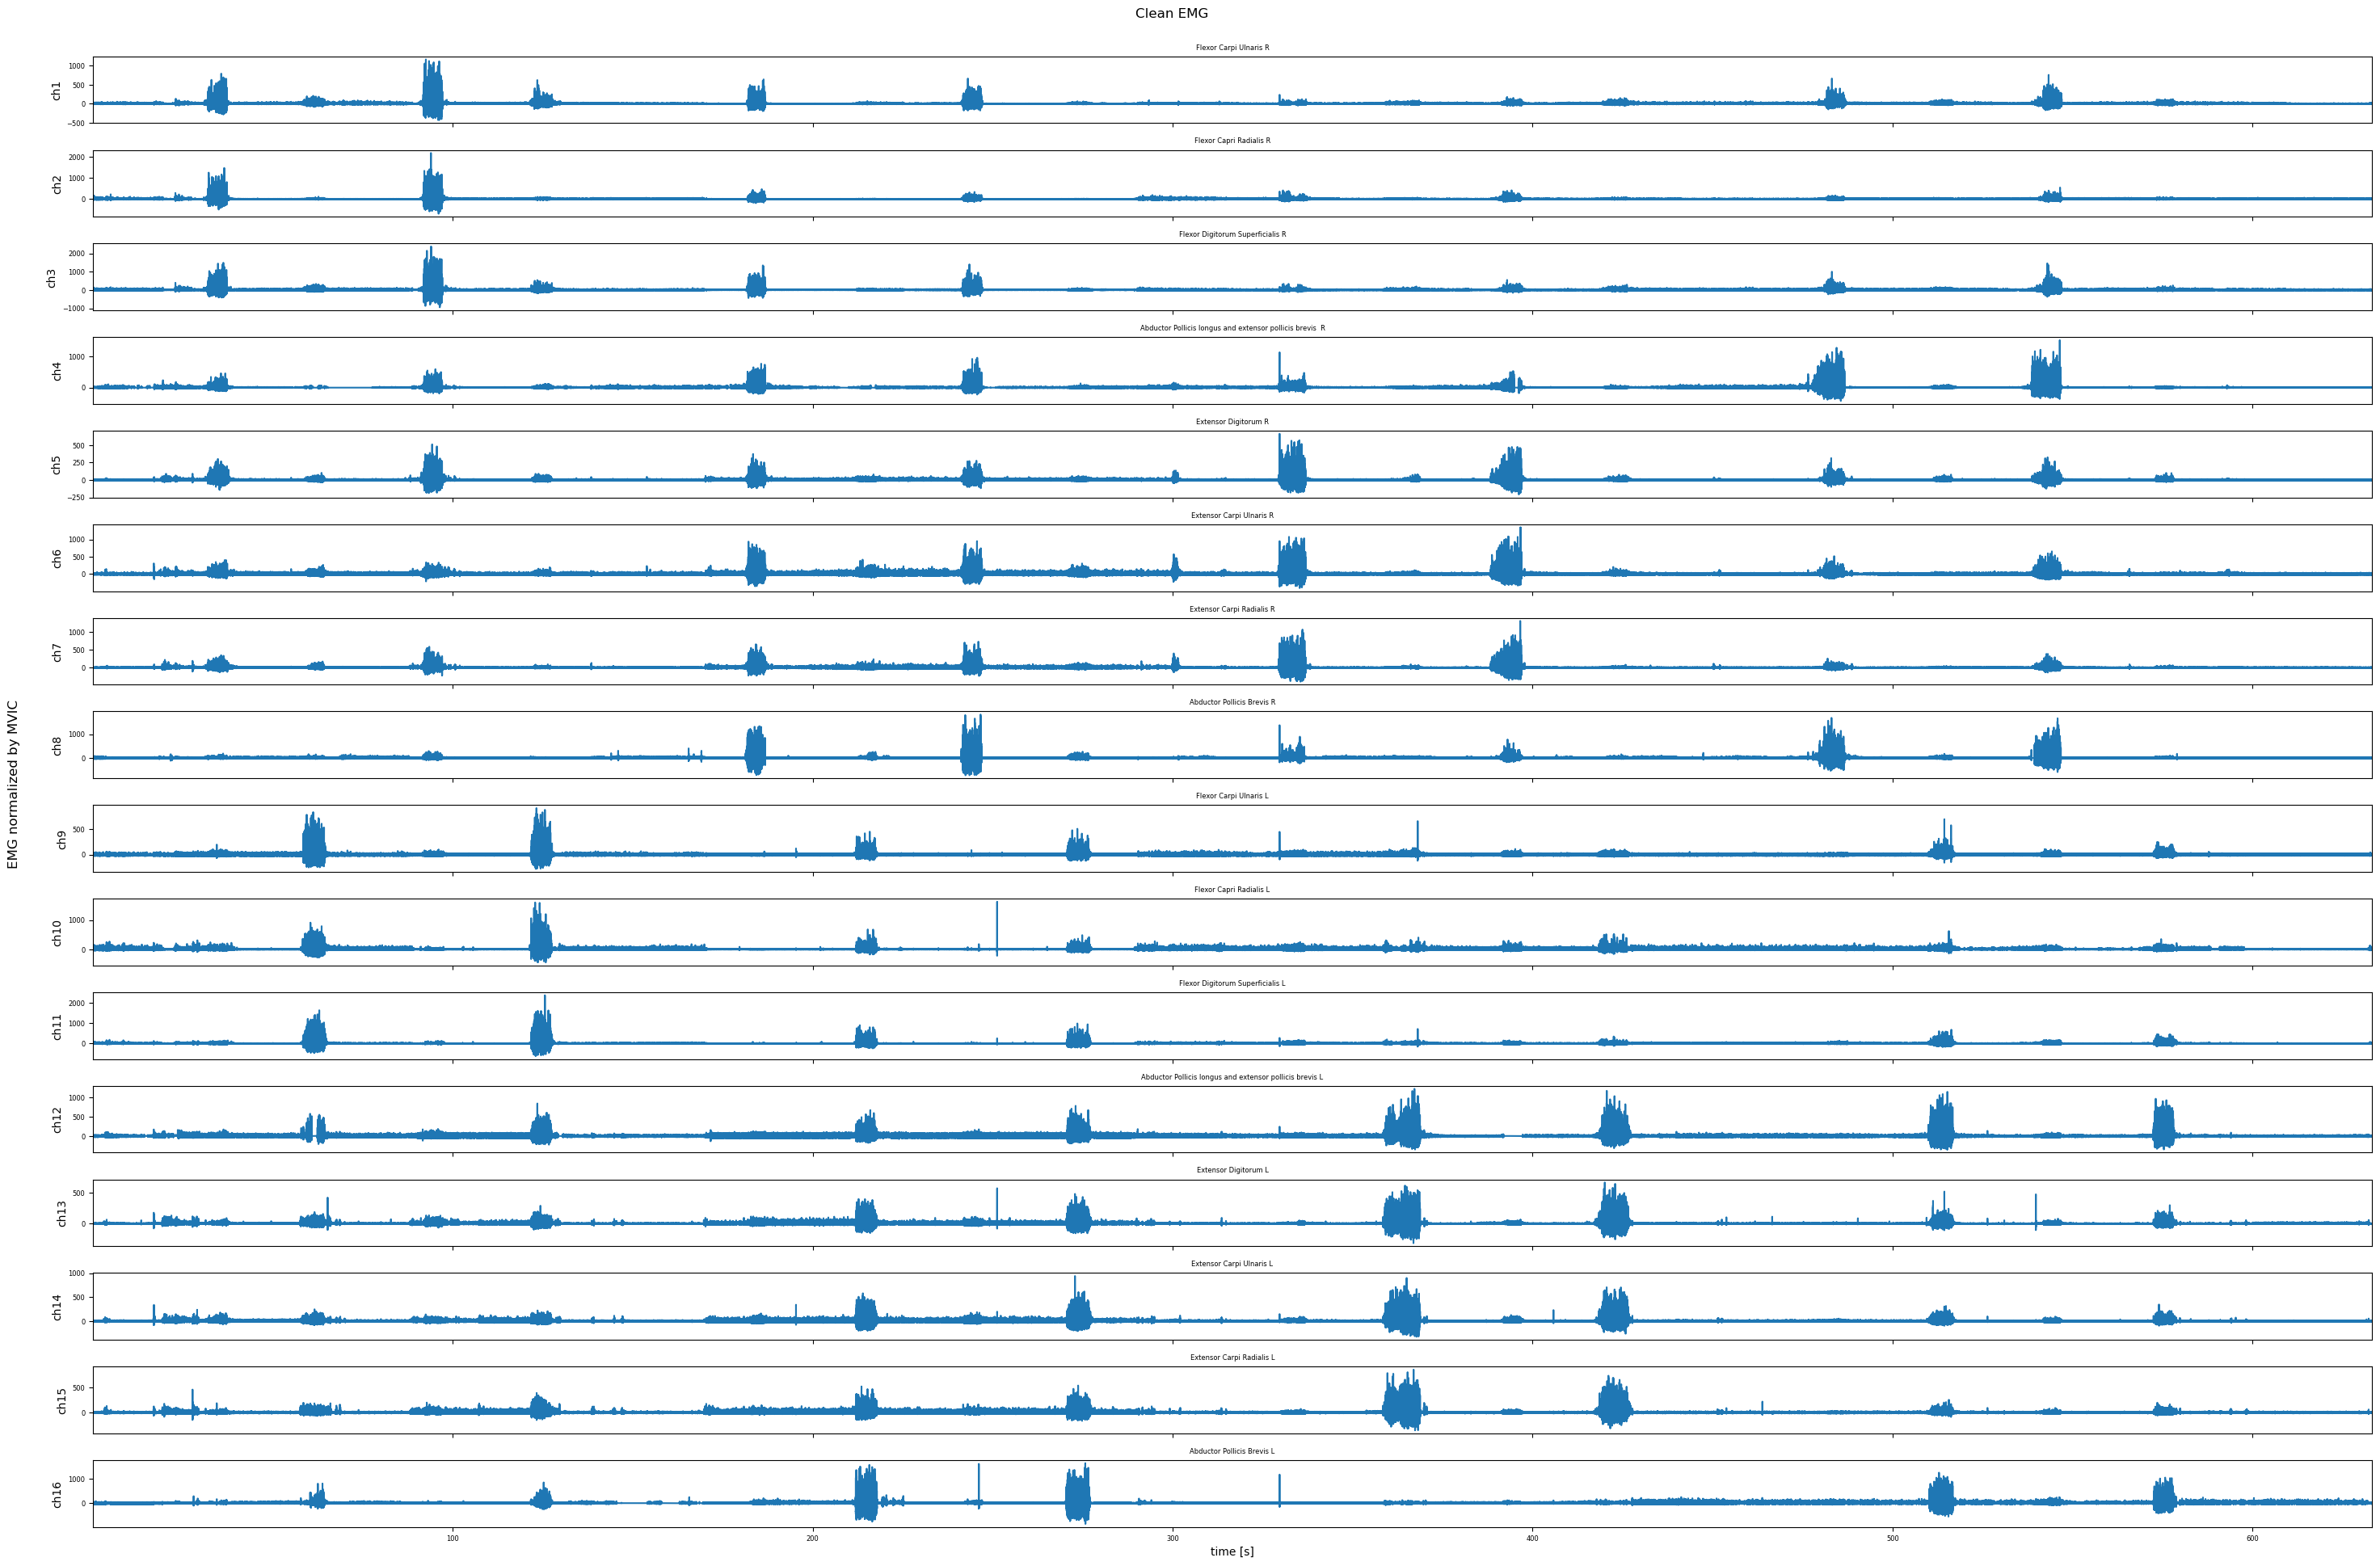

In [10]:
myfct.plot_emgDF(butt_calib)

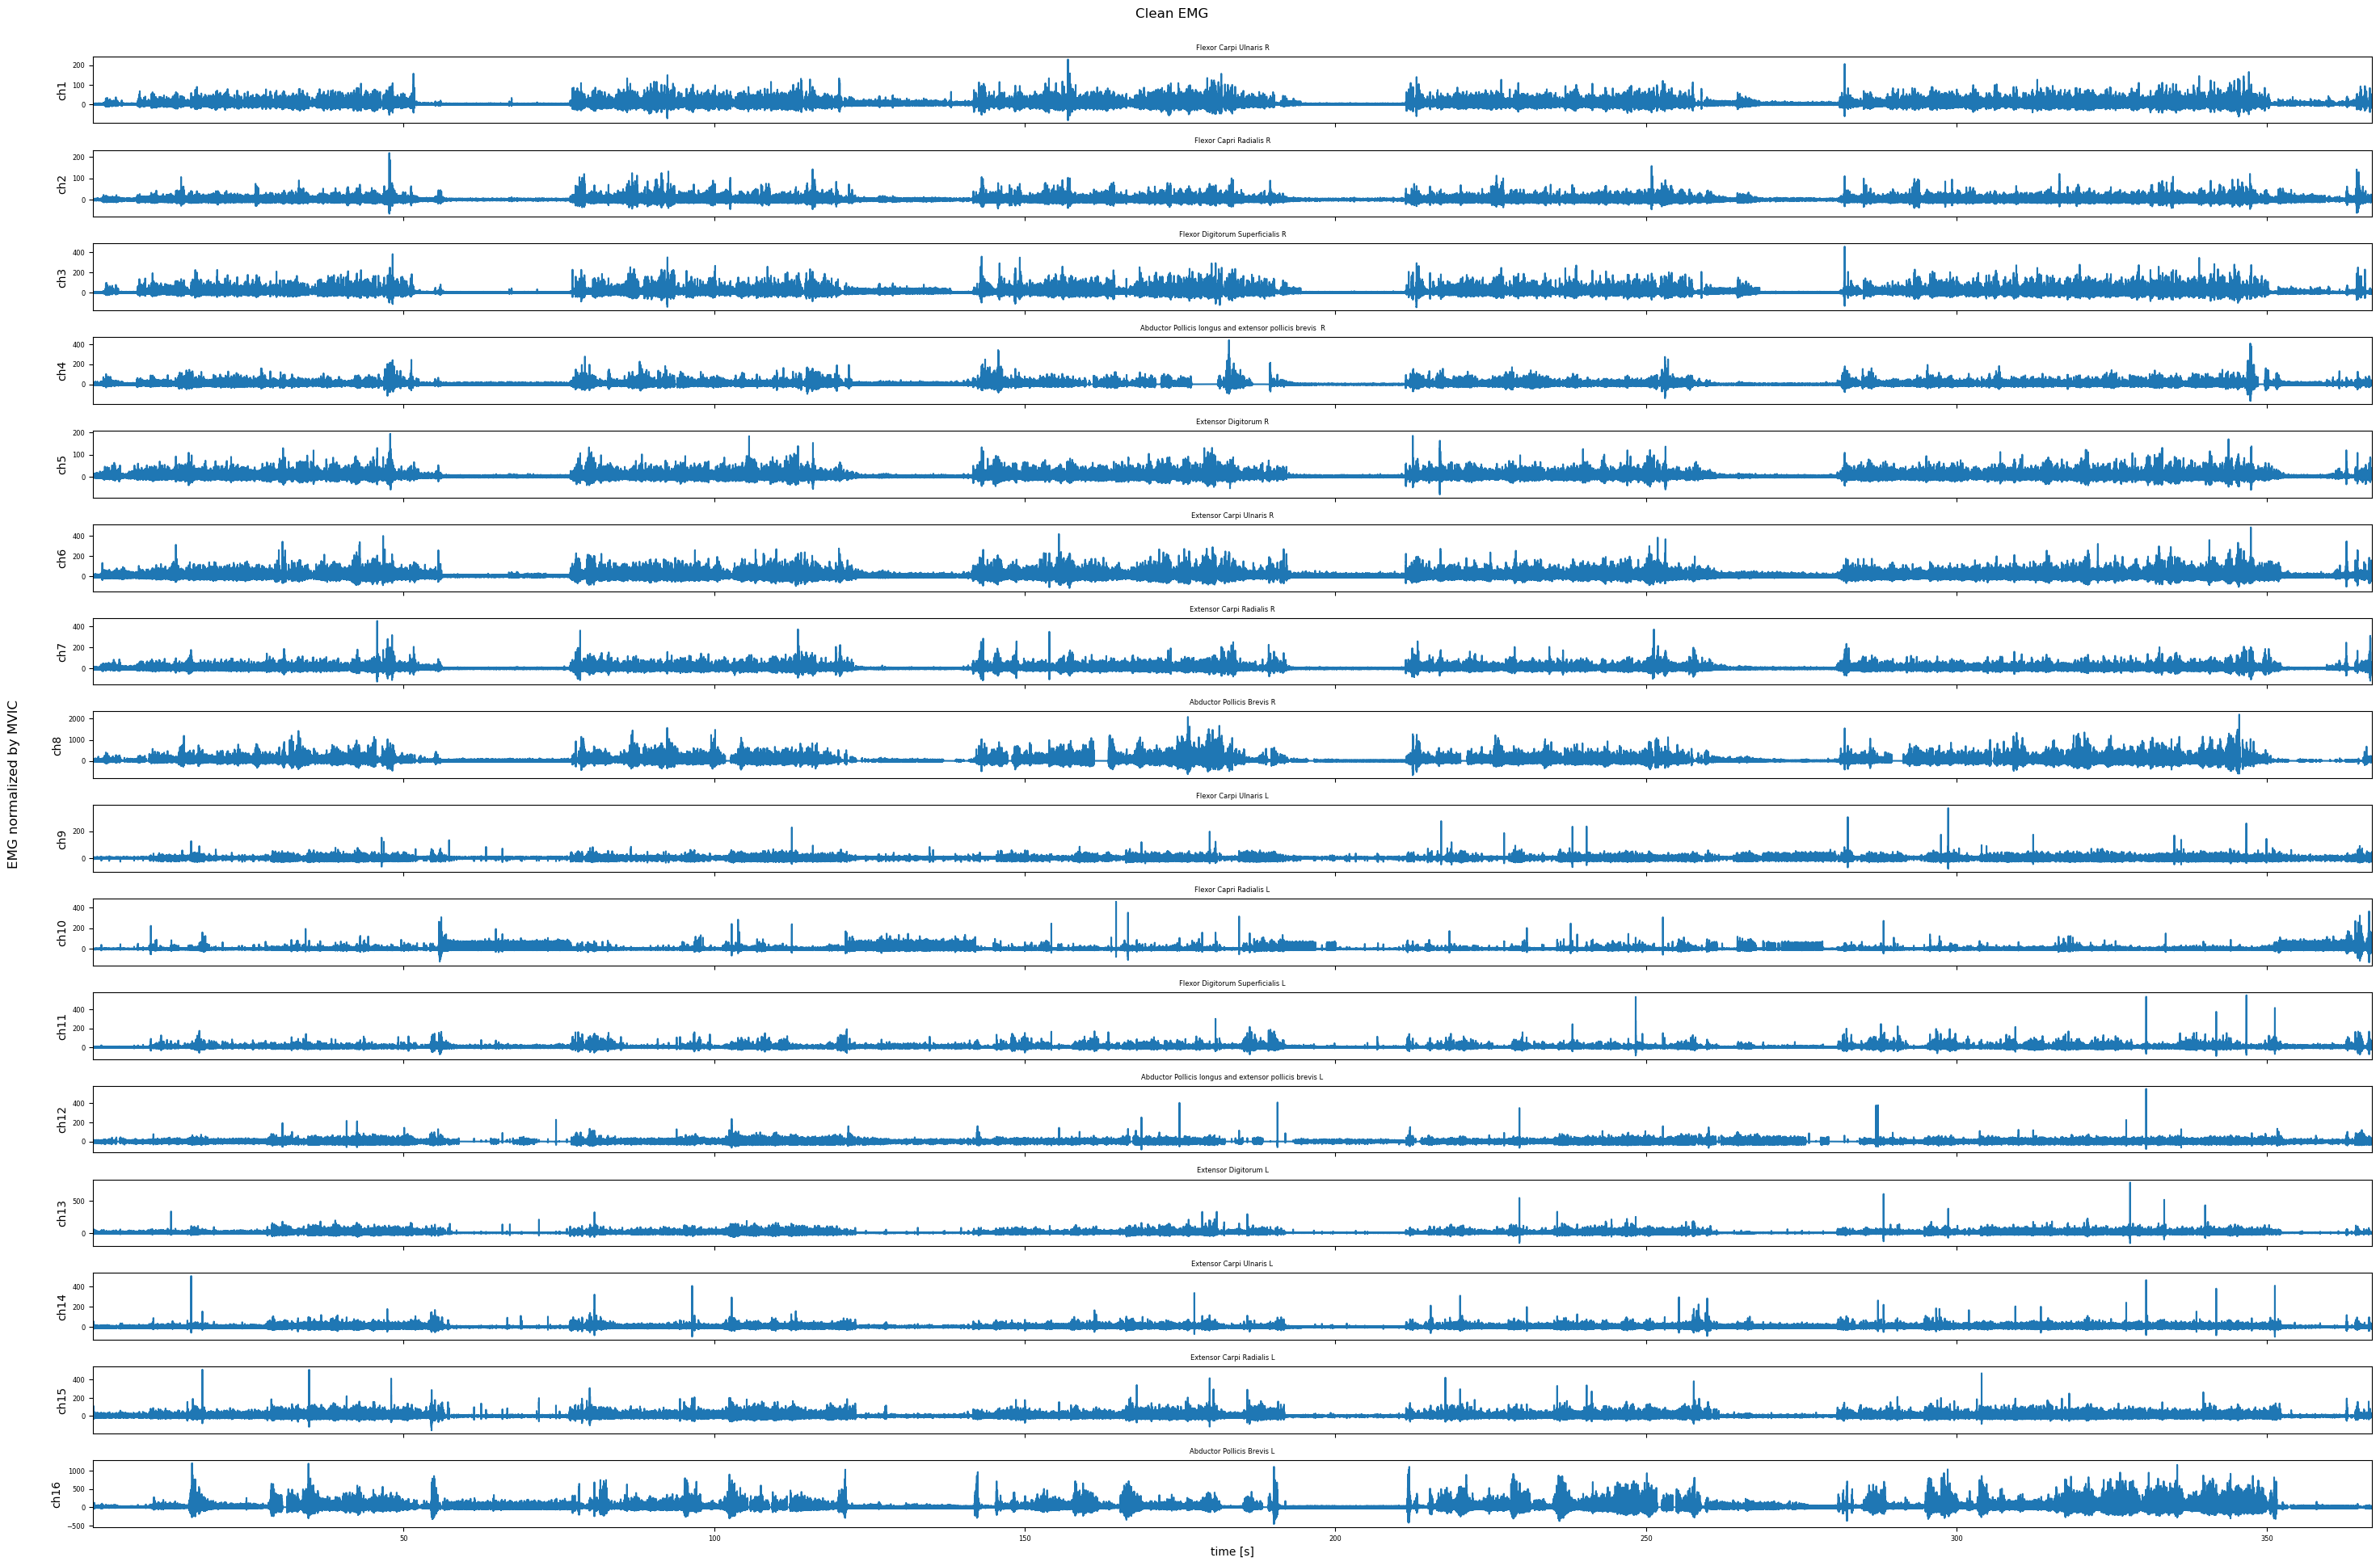

In [11]:
myfct.plot_emgDF(butt)

### Interpolation and rectification

In [12]:
interp_calib = myfct.interpolate_clean_emg(butt_calib, start_idx=0)
interp_calib = abs(interp_calib) #rectify 

interpDF = myfct.interpolate_clean_emg(butt, start_idx=50)
interpDF = abs(interpDF) # rectify

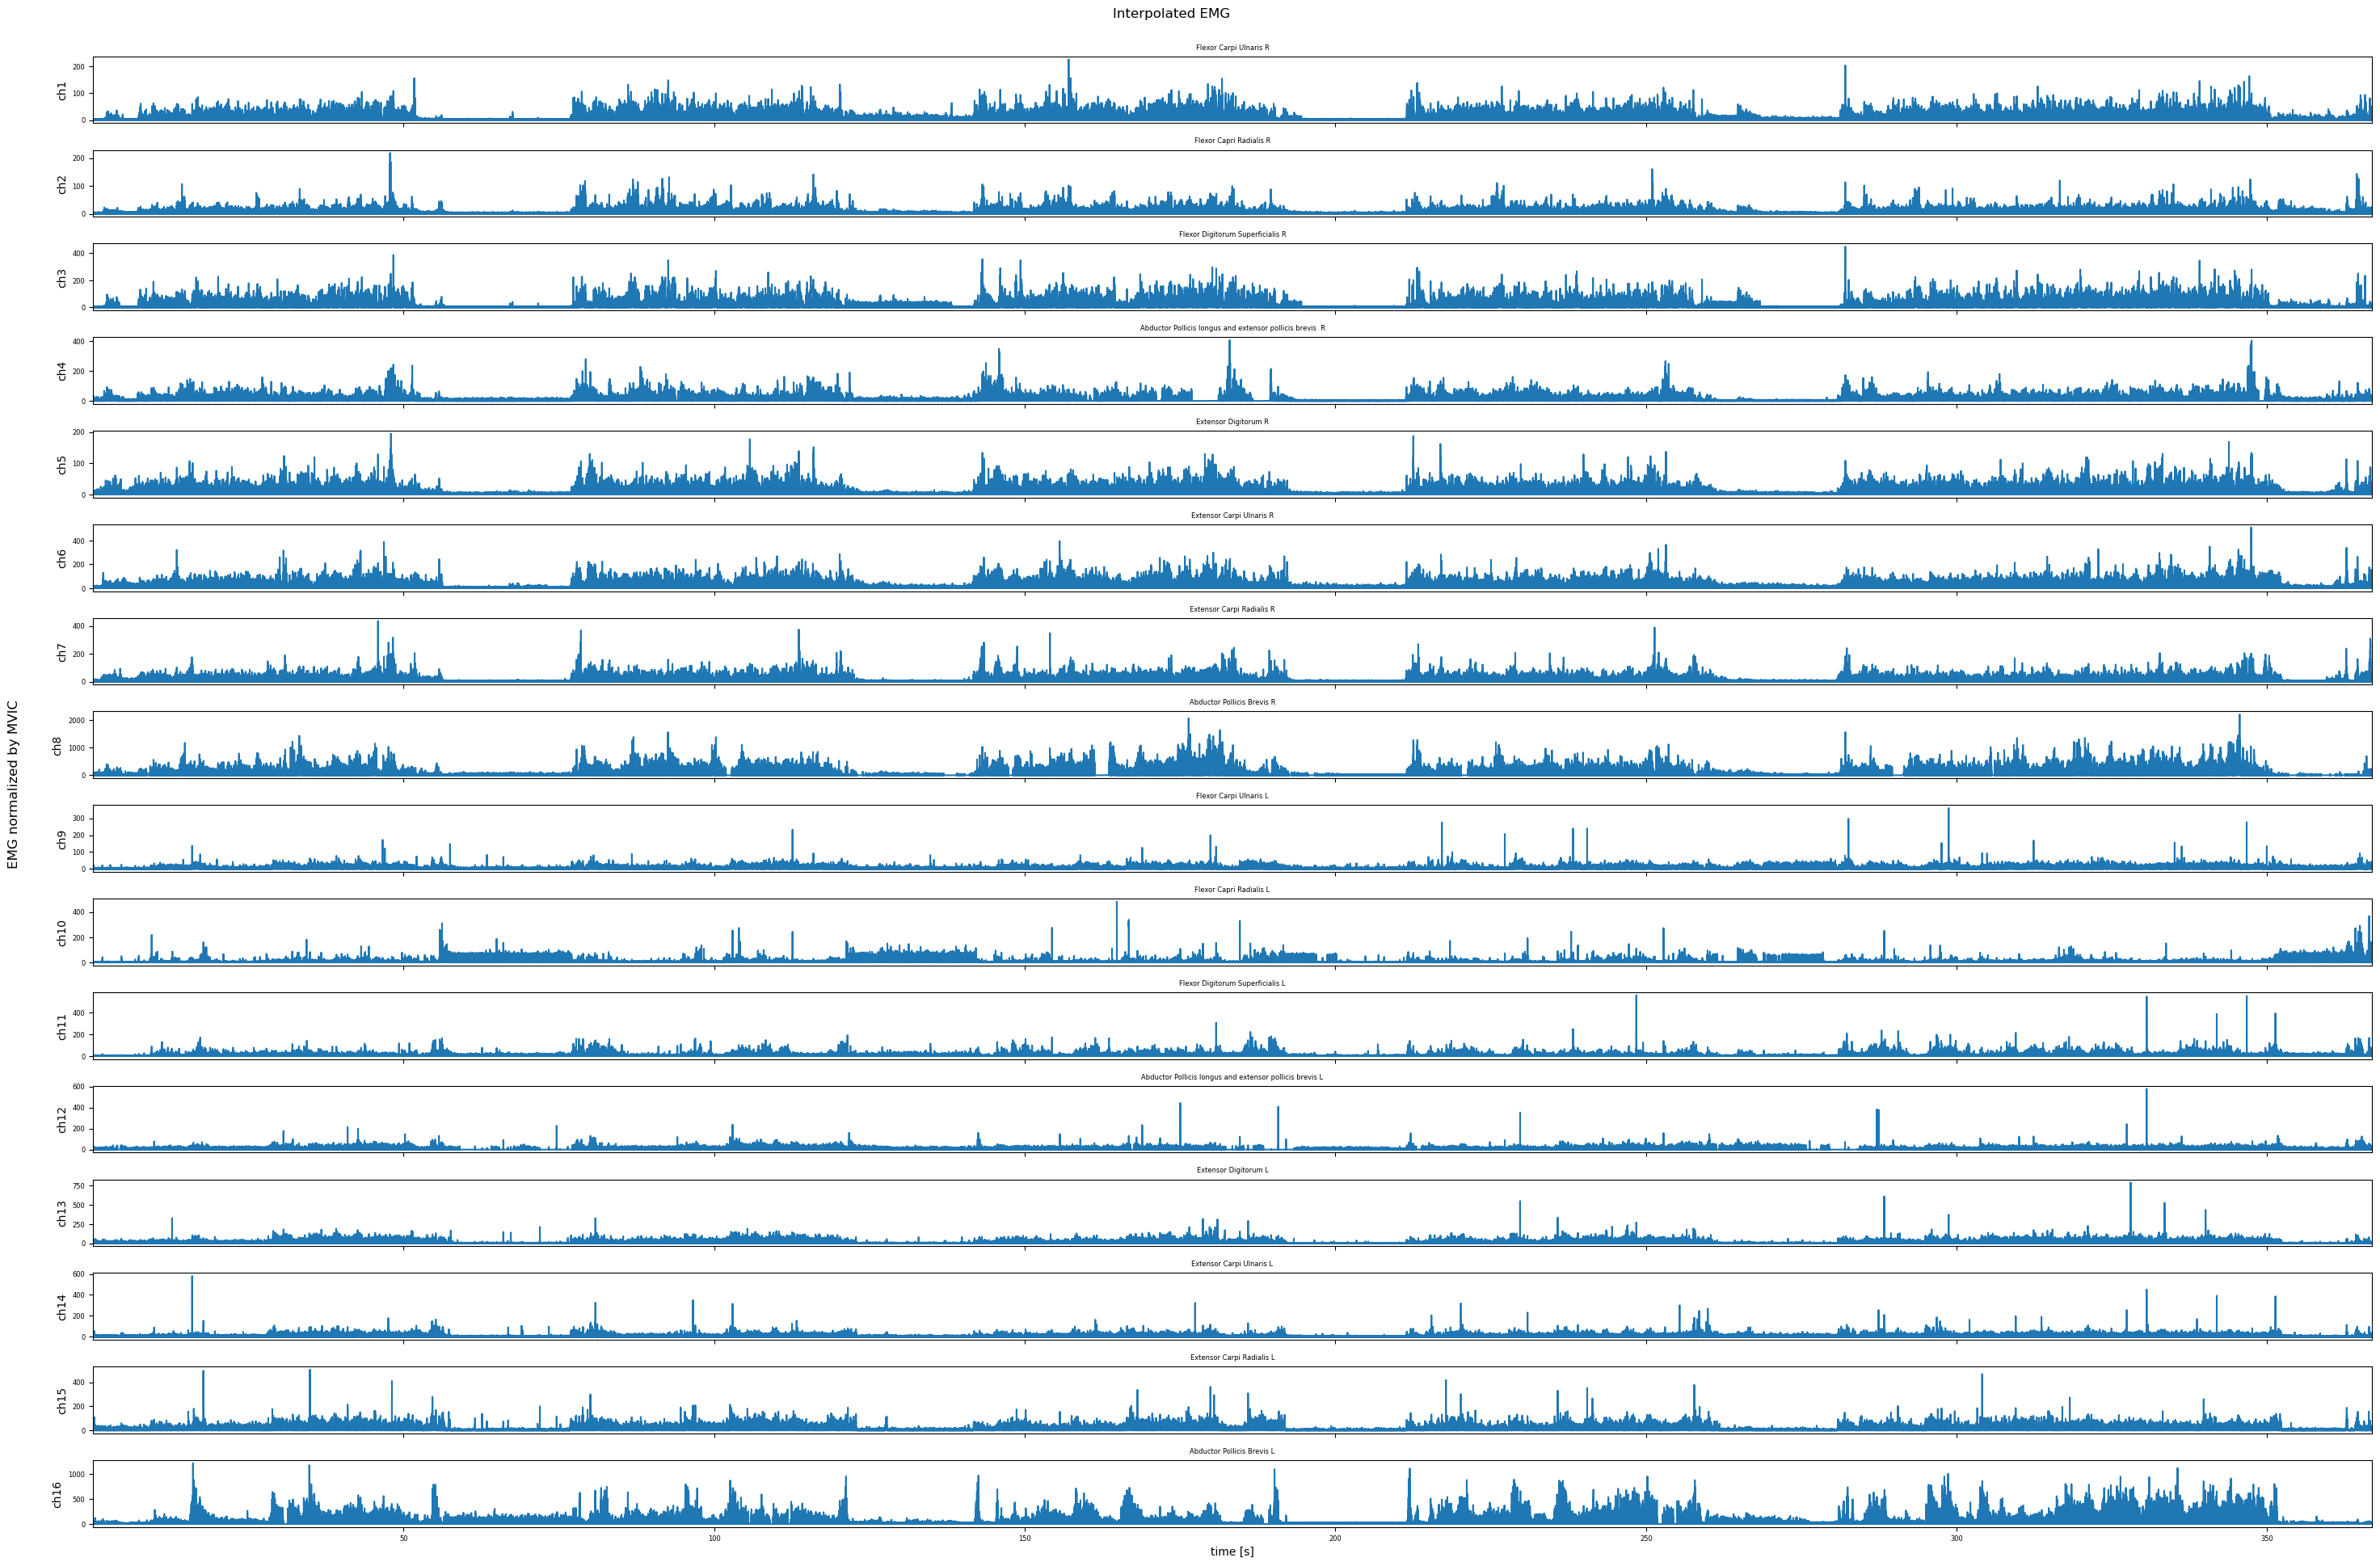

In [13]:
myfct.plot_emgDF(interpDF, title_str='Interpolated EMG')

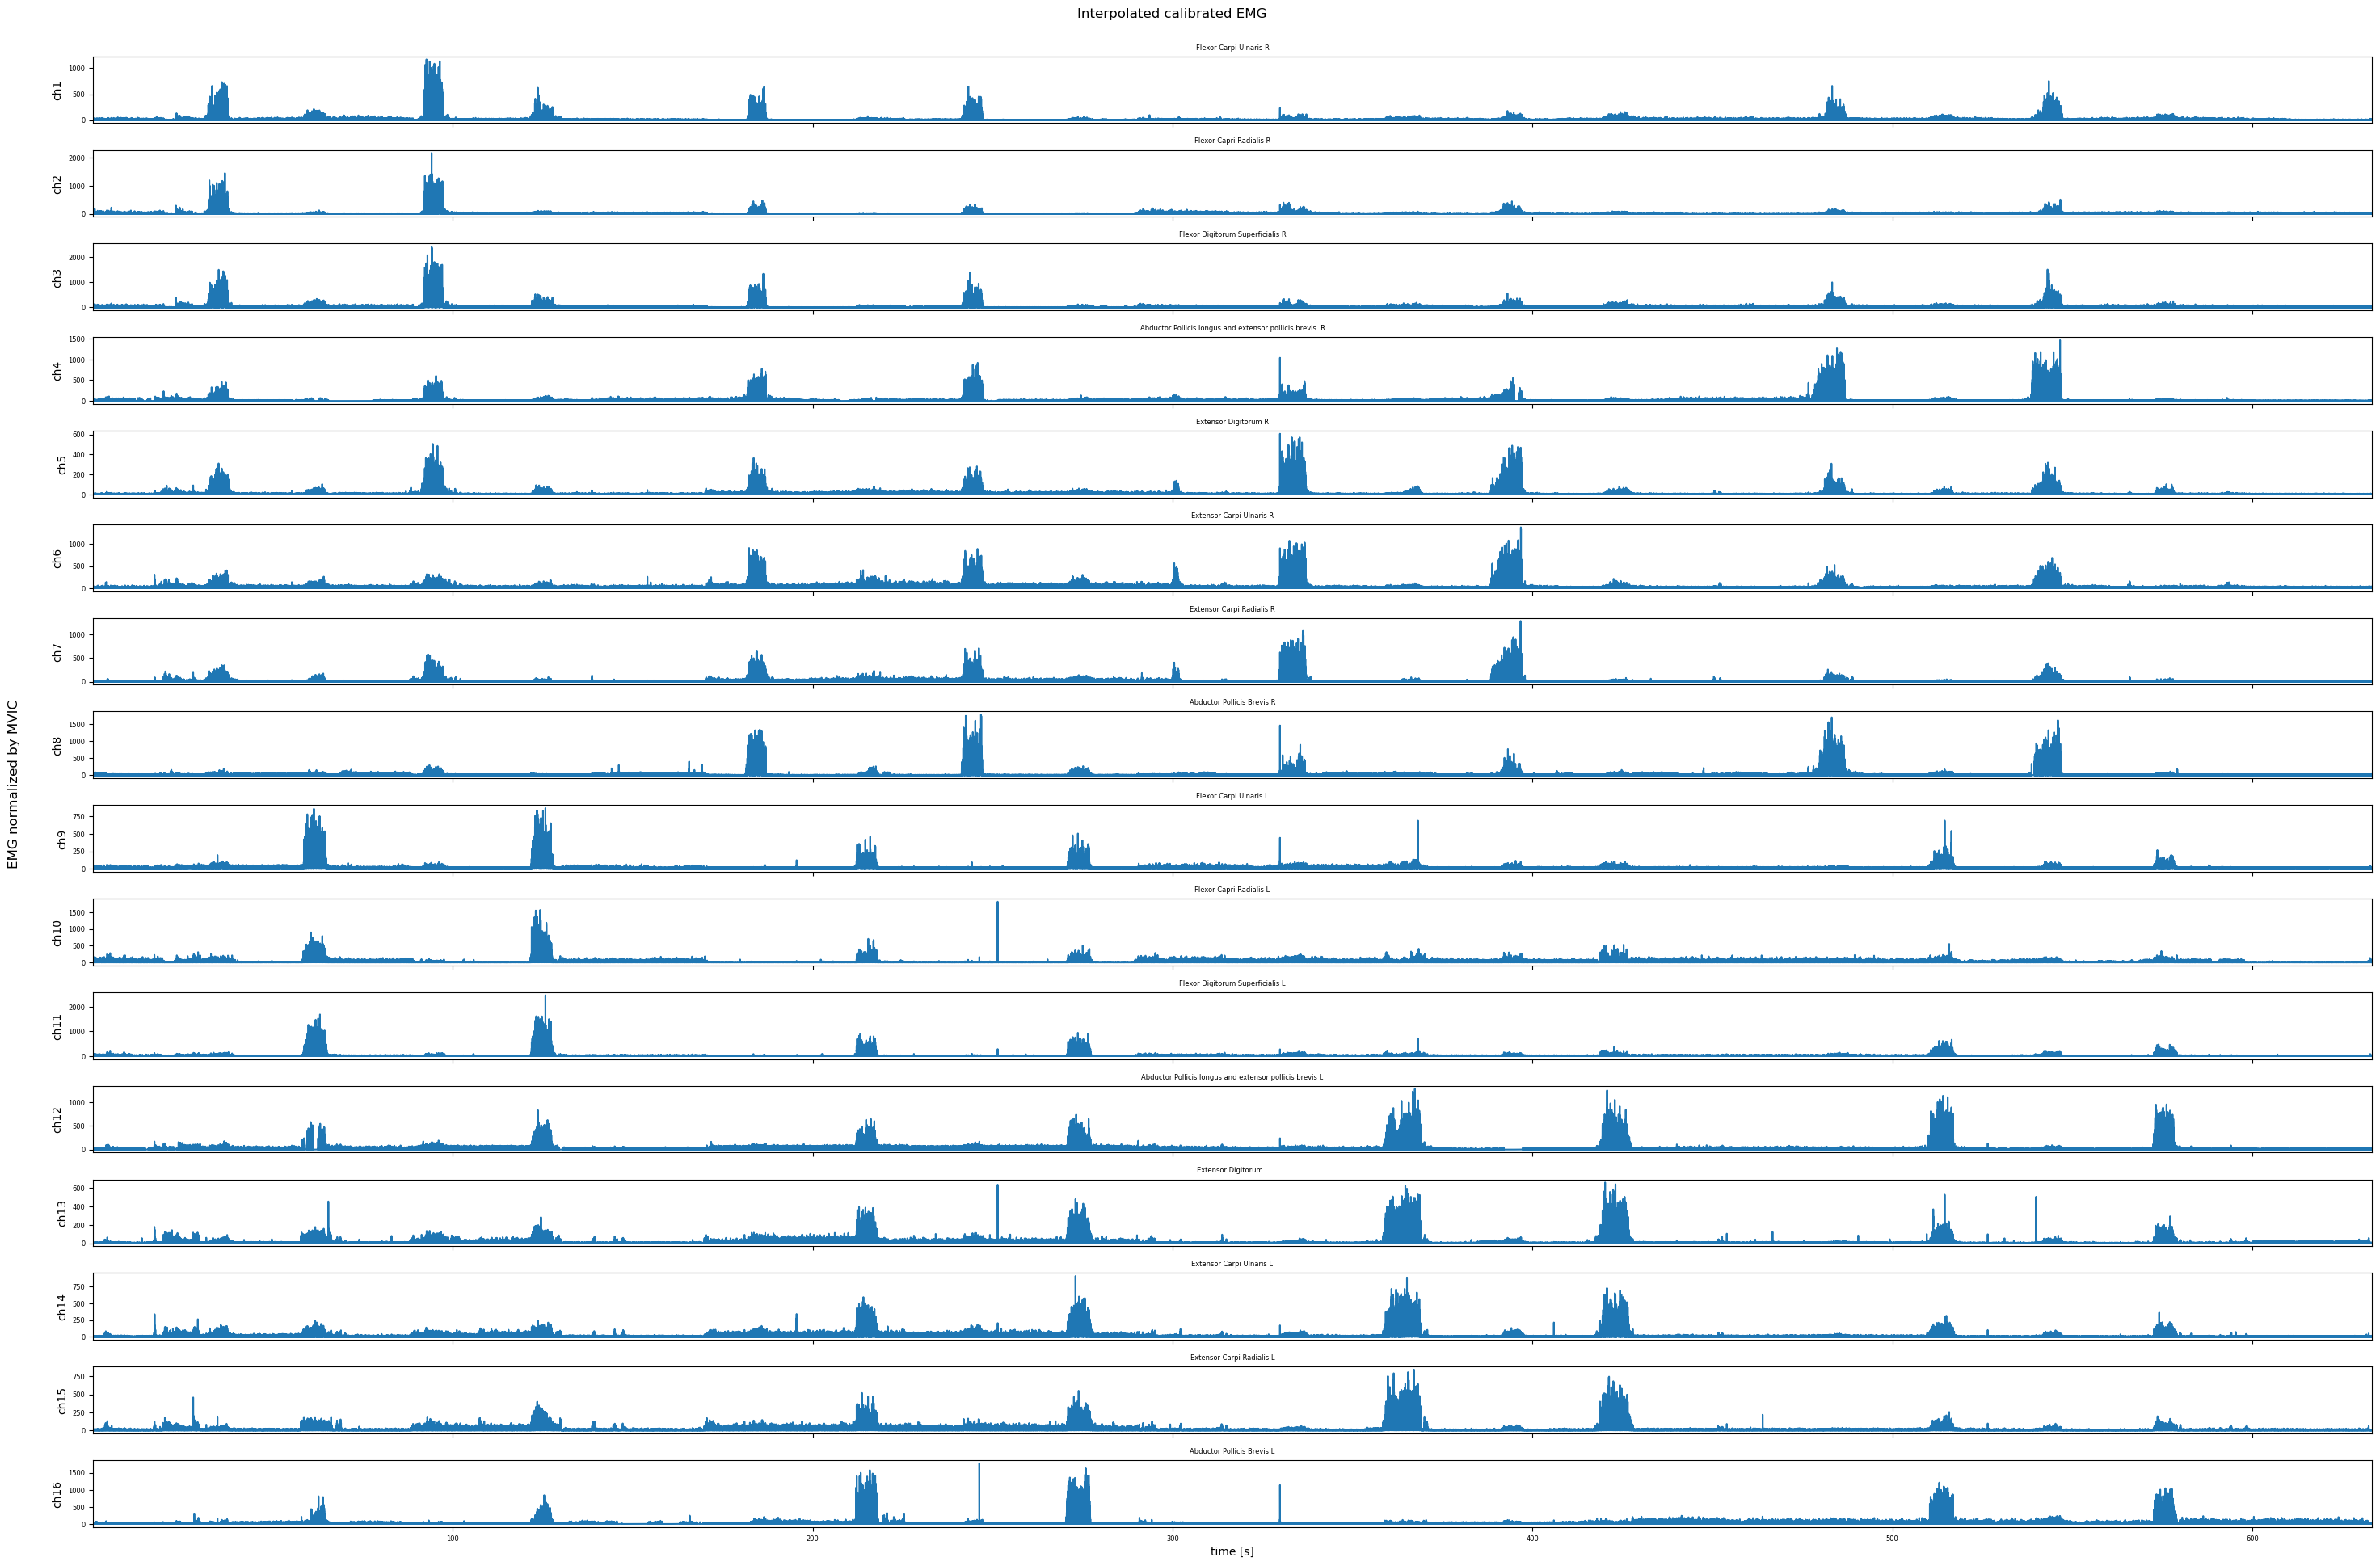

In [14]:
myfct.plot_emgDF(interp_calib, title_str='Interpolated calibrated EMG')

### Amplitude normalization 

In [15]:
norm_calib = myfct.normalization(interp_calib, interp_calib) #just to verify
normDF = myfct.normalization(interpDF, interp_calib)

### Plotting the filters 

In [16]:
idx_label_studied = 15
label_studied = cleanemg_calib.columns.values.tolist()[idx_label_studied]

C:\Users\cabasse\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



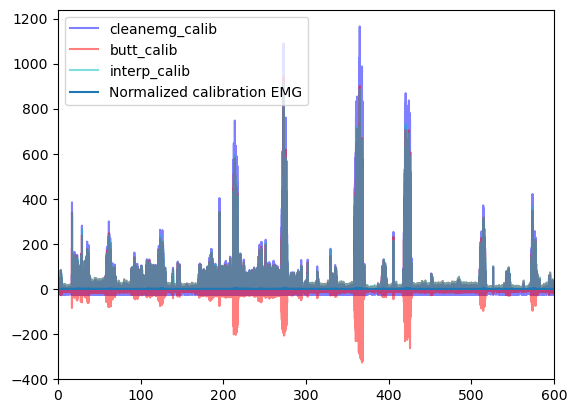

In [17]:
plt.plot(cleanemg_calib["relative time"], cleanemg_calib[label_studied], color= 'b', label = "cleanemg_calib", alpha = 0.5)
plt.plot(butt_calib["relative time"], butt_calib[label_studied], color= 'r', label = "butt_calib", alpha = 0.5)
plt.plot(interp_calib["relative time"], interp_calib[label_studied], color= 'c', label = "interp_calib", alpha = 0.5)
plt.plot(norm_calib["relative time"], norm_calib[label_studied], label='Normalized calibration EMG')

plt.legend()
plt.xlim([0, 600])
plt.show()

## Feature extraction

In [18]:
labels_list = cleanemg_calib.columns.values.tolist() #takes all the names of the columns into a list
window_length = 300

### Time domain 

#### Linear envelope: creates lowpass filter and apply to rectified signal to get EMG envelope

In [19]:
low_pass = 8/(SR/2) #8Hz is the Fc
b2, a2 = sp.butter(4, low_pass, btype='lowpass')
envelopeDF = normDF.copy()
for label in labels_list[2:]:
    envelopeDF[label] = sp.filtfilt(b2, a2, normDF[label].values)

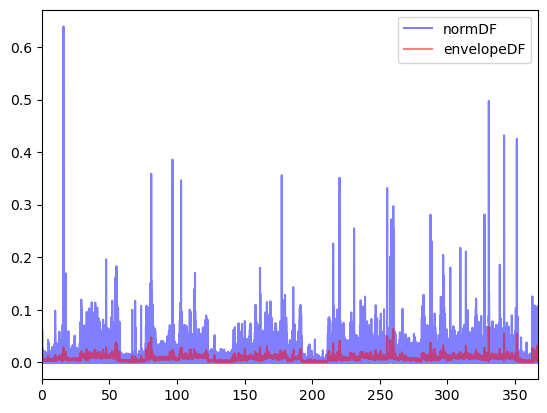

In [20]:
plt.plot(normDF["relative time"], normDF[label_studied], color= 'b', label = "normDF", alpha = 0.5)
plt.plot(envelopeDF["relative time"], envelopeDF[label_studied], color= 'r', label = "envelopeDF", alpha = 0.5)

plt.legend()
plt.xlim([0, cleanemgDF['relative time'].iloc[-1]])
plt.show()

##### Gaussian moving window on linear envelope

In [21]:
gaussDF = envelopeDF.copy() #gaussian smoothing on envelopeDF
for label in labels_list[2:]:
    gaussDF[label] = gaussDF[label].rolling(window = 450, win_type='gaussian', center=True).sum(std=1)

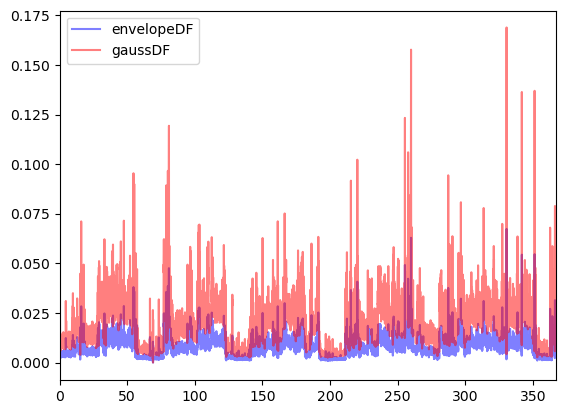

In [22]:
plt.plot(envelopeDF["relative time"], envelopeDF[label_studied], color= 'b', label = "envelopeDF", alpha = 0.5)
plt.plot(gaussDF["relative time"], gaussDF[label_studied], color= 'r', label = "gaussDF", alpha = 0.5)

plt.legend()
plt.xlim([0, cleanemgDF['relative time'].iloc[-1]])
plt.show()

##### Hamming moving window on linear envelope

In [23]:
hammDF = envelopeDF.copy()
for label in labels_list[2:]:
    hammDF[label] = hammDF[label].rolling(window = 5, win_type='hamming', center=True).sum()

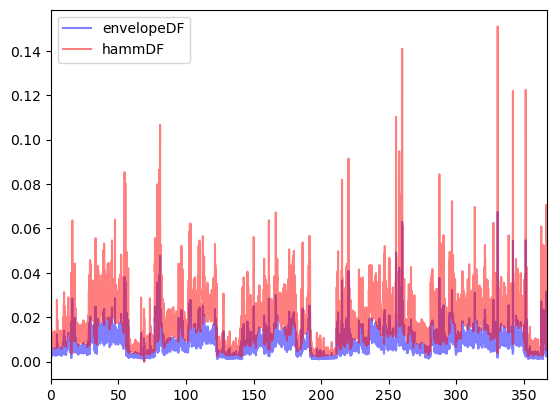

In [24]:
plt.plot(envelopeDF["relative time"], envelopeDF[label_studied], color= 'b', label = "envelopeDF", alpha = 0.5)
plt.plot(hammDF["relative time"], hammDF[label_studied], color= 'r', label = "hammDF", alpha = 0.5)
plt.legend()
plt.xlim([0, cleanemgDF['relative time'].iloc[-1]])
plt.show()

#### Integrated EMG - pre-activation index for muscle activity

In [25]:
iemgDF = normDF.copy()
for label in labels_list[2:]:
    iemgDF[label] = abs(iemgDF[label]).rolling(window = window_length).sum()
iemgDF = iemgDF.dropna() #first 300 points are nan

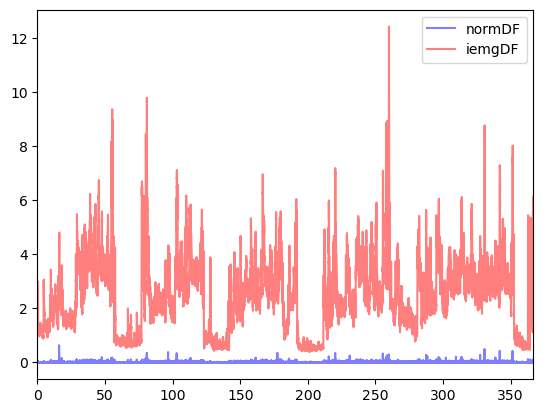

In [26]:
plt.plot(normDF["relative time"], normDF[label_studied], color= 'b', label = "normDF", alpha = 0.5)
plt.plot(iemgDF["relative time"], iemgDF[label_studied], color= 'r', label = "iemgDF", alpha = 0.5)
plt.legend()
plt.xlim([0, normDF['relative time'].iloc[-1]])
plt.show()

#### Mean absolute value (MAV) 

In [27]:
mavDF = normDF.copy()
for label in labels_list[2:]:
    mavDF[label] = (1/window_length)*abs(mavDF[label]).rolling(window = window_length).sum()
mavDF = mavDF.dropna()#first window_length points are nan

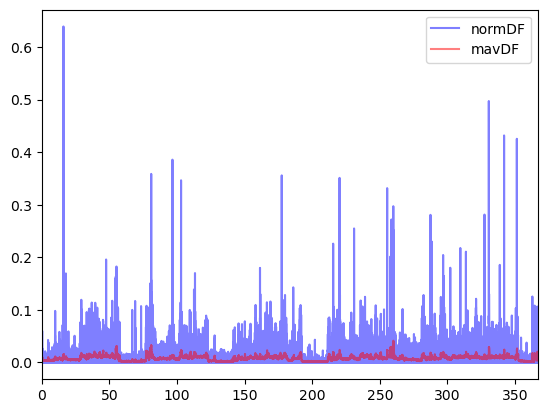

In [28]:
plt.plot(normDF["relative time"], normDF[label_studied], color= 'b', label = "normDF", alpha = 0.5)
plt.plot(mavDF["relative time"], mavDF[label_studied], color= 'r', label = "mavDF", alpha = 0.5)
plt.legend()
plt.xlim([0, normDF['relative time'].iloc[-1]])
plt.show()

#### Mean absolute value slope (MAVS) - estimation of the difference between the MAVs of the adjacent segments

In [ ]:
mavsDF = mavDF.copy()
for label in labels_list[2:]:
    for i in range(mavsDF.shape[0]):
        mavsDF[label].iloc[i] = mavDF[label].iloc[i+1] - mavDF[label].iloc[i] 

In [ ]:
plt.plot(normDF["relative time"], normDF[label_studied], color= 'b', label = "normDF", alpha = 0.5)
plt.plot(mavsDF["relative time"], mavsDF[label_studied], color= 'r', label = "mavsDF", alpha = 0.5)
plt.legend()
plt.xlim([0, normDF['relative time'].iloc[-1]])
plt.show()

In [ ]:
diff_mavDF = mavDF.copy()
for label in labels_list[2:]:
    diff_mavDF[label] = mavDF[label].diff()
diff_mavDF = diff_mavDF.dropna()

In [ ]:
plt.plot(diff_mavDF["relative time"], diff_mavDF[label_studied], color= 'b', label = "diff_mavDF", alpha = 0.5)
plt.plot(mavsDF["relative time"], mavsDF[label_studied], color= 'r', label = "mavsDF", alpha = 0.5)
plt.legend()
plt.xlim([0, normDF['relative time'].iloc[-1]])
plt.show()

#### Single square integral (SSI) - energy of the EMG signal 

In [ ]:
ssiDF = normDF.copy()
for label in labels_list[2:]:
    ssiDF[label] = (abs(ssiDF[label])**2).rolling(window = 300).sum()
ssiDF = ssiDF.dropna() #first 300 points are nan

In [ ]:
plt.plot(normDF["relative time"], normDF[label_studied], color= 'b', label = "normDF", alpha = 0.5)
plt.plot(ssiDF["relative time"], ssiDF[label_studied], color= 'r', label = "ssiDF", alpha = 0.5)
plt.legend()
plt.xlim([0, normDF['relative time'].iloc[-1]])
plt.show()

#### Variance - Power of EMG

In [ ]:
varDF = normDF.copy()
for label in labels_list[2:]:
    varDF[label] = (1/(window_length-1))*(varDF[label]**2).rolling(window = window_length).sum()
varDF = varDF.dropna()#first window_length points are nan

In [ ]:
plt.plot(normDF["relative time"], normDF[label_studied], color= 'b', label = "normDF", alpha = 0.5)
plt.plot(varDF["relative time"], varDF[label_studied], color= 'r', label = "varDF", alpha = 0.5)
plt.legend()
plt.xlim([0, normDF['relative time'].iloc[-1]])
plt.show()

#### Root Mean Square - amplitude modulated Gaussian random process where the RMS is related to the constant force, and the non-fatigue constractions of the muscles

In [ ]:
rmsDF = normDF.copy()
for label in labels_list[2:]:
    rmsDF[label] = ((rmsDF[label]**2).rolling(window = window_length).mean()) **0.5
rmsDF = rmsDF.dropna()#first window_length points are nan

In [ ]:
plt.plot(normDF["relative time"], normDF[label_studied], color= 'b', label = "normDF", alpha = 0.5)
plt.plot(rmsDF["relative time"], rmsDF[label_studied], color= 'r', label = "rmsDF", alpha = 0.5)
plt.legend()
plt.xlim([0, normDF['relative time'].iloc[-1]])
plt.show()

#### Waveform Length - cumulative length of the waveform over the segment

In [ ]:
wlDF = normDF.copy()

for label in labels_list[2:]:
    for i in range(wlDF.shape[0]):
        wlDF[label].iloc[i]= abs(normDF[label].iloc[i+1] - normDF[label].iloc[i])
    wlDF[label] = wlDF[label].rolling(window = window_length).sum()
    
wlDF = wlDF.dropna() #first 300 points are nan

In [ ]:
plt.plot(normDF["relative time"], normDF[label_studied], color= 'b', label = "normDF", alpha = 0.5)
plt.plot(wlDF["relative time"], wlDF[label_studied], color= 'r', label = "wlDF", alpha = 0.5)
plt.legend()
plt.xlim([0, normDF['relative time'].iloc[-1]])
plt.show()

#### Sample entropy

In [ ]:
#SampEnDF,_ = EH.SampEn(cleanemgDF[label_studied], m=2, r = 0.2 * np.std(cleanemgDF[label_studied])) 

### Frequency domain

#### RMS

In [ ]:
rmsDF = myfct.rms_filter(normDF)

plt.plot(normDF["relative time"], normDF[label_studied], color= 'b', label = "normDF", alpha = 0.5)
plt.plot(rmsDF["relative time"], rmsDF[label_studied], color= 'r', label = "rmsDF", alpha = 0.5)

plt.legend()
plt.xlim([0, cleanemgDF['relative time'].iloc[-1]])
plt.show()

#### Power spectrum of the normalized dataframe

In [ ]:
Pxx_spec = pd.DataFrame(columns=labels_list)
f = pd.DataFrame(columns=labels_list)
RMSamplitude = []
for label in labels_list[2:]:
    f[label], Pxx_spec[label] = sp.periodogram(normDF[label], SR, 'flattop', scaling='spectrum')

    # The peak height in the power spectrum is an estimate of the RMS amplitude.
    RMSamplitude.append(np.sqrt(Pxx_spec[label].max()))

print('Peak height of power spectrum = ' + str(round(RMSamplitude[idx_label_studied], 4)) + ' Hz')

plt.semilogy(f[label_studied], np.sqrt(Pxx_spec[label_studied]), color= 'r', label = "Power spectrum DF")
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')

### Time-frequency domain

#### Daubechies wavelet transforms

##### Looking for the best filter

In [ ]:
#TODO : Verify why normDF[label_studied].shape = 550277 and w1.shape = 550278

In [ ]:
w1 = myfct.lowpassfilter(normDF[label_studied], thresh = 0.05, wavelet="db1")
w2 = myfct.lowpassfilter(normDF[label_studied], thresh = 0.05, wavelet="db2")
w4 = myfct.lowpassfilter(normDF[label_studied], thresh = 0.05, wavelet="db4")
w6 = myfct.lowpassfilter(normDF[label_studied], thresh = 0.05, wavelet="db6")
w20 = myfct.lowpassfilter(normDF[label_studied], thresh = 0.05, wavelet="db20")

fig, axs = plt.subplots(5, 1, sharex='col')
axs[0].plot(normDF["relative time"], normDF[label_studied], normDF["relative time"], w1[:-1], label='db4' )
axs[1].plot(normDF["relative time"], normDF[label_studied], normDF["relative time"], w2[:-1], label='db2' )
axs[2].plot(normDF["relative time"], normDF[label_studied], normDF["relative time"], w4[:-1], label='db4' )
axs[3].plot(normDF["relative time"], normDF[label_studied], normDF["relative time"], w6[:-1], label='db6' )
axs[4].plot(normDF["relative time"], normDF[label_studied], normDF["relative time"], w20[:-1], label='db20' )

axs[0].set_ylabel('normDF and db1 (mV)')
axs[1].set_ylabel('normDF and db2 (mV)')
axs[2].set_ylabel('normDF and db4 (mV)')
axs[3].set_ylabel('normDF and db6 (mV)')
axs[4].set_ylabel('normDF and db20 (mV)')

fig.tight_layout()
plt.subplots_adjust(top=0.95,
                    bottom=0.04,
                    left=0.055,
                    right=0.995,
                    hspace=0.4,
                    wspace=0.2)
plt.xlim([0, normDF['relative time'].iloc[-1]])

axs[4].set_xlabel('Time')
plt.show()

The best result is for db4 and a threashold of 0.05

##### Plotting the best filter

In [ ]:
plt.plot(cleanemgDF["relative time"], cleanemgDF[label_studied], color= 'b', label = "cleanemgDF", alpha = 0.5)
plt.plot(cleanemgDF["relative time"], w4, color= 'r', label = "db 4", alpha = 0.5)

plt.legend()
plt.xlim([0, cleanemgDF['relative time'].iloc[-1]])
plt.show()